In [27]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import seaborn as sns

In [28]:
df: DataFrame = pd.read_csv('../../data/processed/processed_features.csv')
df[['year', 'month', 'weekday', 'hour', 'pickup_neighborhood',
    'dropoff_neighborhood']] = df[
    ['year', 'month', 'weekday', 'hour', 'pickup_neighborhood',
     'dropoff_neighborhood']].astype('category')
df.head()

,year,month,weekday,hour,pickup_neighborhood,passenger_count,distance,dropoff_neighborhood,fare
0,2015,5,3,15,West Village,1.0,1.681111,SoHo,7.5
1,2009,7,4,16,NoHo,1.0,2.454363,Chelsea,7.7
2,2009,8,0,17,West Village,1.0,5.039603,Upper East Side,12.9
3,2009,6,4,4,Upper West Side,3.0,1.661442,Upper West Side,5.3
4,2014,8,3,13,Sunnyside,5.0,4.483730,Midtown,16.0


In [29]:
X_columns = df.columns.tolist()
# X_columns = X_columns[47:]
X_columns.remove('fare')
X = df[X_columns]
Y = df['fare']
X_columns

['year',
 'month',
 'weekday',
 'hour',
 'pickup_neighborhood',
 'passenger_count',
 'distance',
 'dropoff_neighborhood']

In [30]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)


class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_cols = X[self.columns]
        return X_cols


num_pipe = Pipeline(
    [('extract',
      ColumnExtractor(columns=['passenger_count', 'distance'])),
     ('poly', PolynomialFeatures(degree=2, include_bias=False))])

cat_pipe = Pipeline(
    [('extract', ColumnExtractor(
        columns=['year', 'month', 'weekday', 'hour', 'pickup_neighborhood',
                 'dropoff_neighborhood'])),
     ('one_hot', OneHotEncoder(handle_unknown='ignore'))])

pipe = Pipeline(
    [('features', FeatureUnion([('num', num_pipe), ('cat', cat_pipe)])),
     ('estimator', AdaBoostRegressor(DecisionTreeRegressor(max_depth=11), n_estimators=50))
     ])

# pipe.fit(X_train, Y_train)
# pipe.score(X_test, Y_test)

In [31]:
parameters = {'estimator__base_estimator': [DecisionTreeRegressor(max_depth=i) for i in np.arange(19, 25)]}

grid = GridSearchCV(pipe, parameters, cv=5, n_jobs=-1)

grid.fit(X_train, Y_train)
grid.score(X_test, Y_test)

0.8556289930649039

<AxesSubplot:>

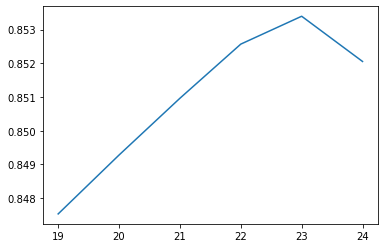

In [32]:
sns.lineplot(x=np.arange(19, 25), y=grid.cv_results_['mean_test_score'])

In [33]:
import joblib

joblib.dump(grid.best_estimator_, 'filename.pkl')

['filename.pkl']

<AxesSubplot:xlabel='distance'>

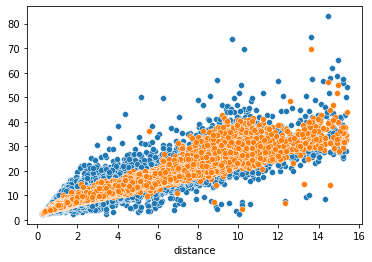

In [34]:
sns.scatterplot(x=X_test['distance'], y=Y_test)
sns.scatterplot(x=X_test['distance'], y=grid.predict(X_test))

<AxesSubplot:>

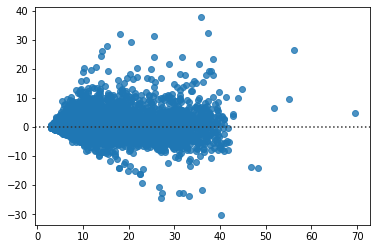

In [35]:
sns.residplot(x=grid.predict(X_test), y=Y_test)

In [36]:
grid.best_estimator_

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('num',
                                                 Pipeline(steps=[('extract',
                                                                  ColumnExtractor(columns=['passenger_count',
                                                                                           'distance'])),
                                                                 ('poly',
                                                                  PolynomialFeatures(include_bias=False))])),
                                                ('cat',
                                                 Pipeline(steps=[('extract',
                                                                  ColumnExtractor(columns=['year',
                                                                                           'month',
                                                                                           'weekday',
    

In [37]:
from datetime import datetime

print(datetime.now())

2022-01-07 02:07:25.352541
